# ANN model Validation

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


columns_to_include = list(range(10))  # This creates a list of integers from 0 to 9
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include)

dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], format='%Y/%m/%d %H:%M')

In [30]:
dataset2 = dataset
dataset2.head()

,Timestamp,Module Temperature,Irradiance,Temperature,Humidity,Pressure,Wind Speed,Wind Direction,Rain,PV yield counter
0,2022-09-10 00:00:00,12.500,7.500,13.7,89.0,1001.4,1.4,330.0,0.0,0.0
1,2022-09-10 01:00:00,12.775,7.528,13.0,90.0,1000.8,1.7,350.0,0.0,0.0
2,2022-09-10 02:00:00,12.262,9.034,13.2,92.0,1000.3,1.4,350.0,0.0,0.0
3,2022-09-10 03:00:00,11.972,9.034,10.2,94.0,999.7,1.4,330.0,0.0,0.0
4,2022-09-10 04:00:00,11.810,8.281,10.7,95.0,999.8,1.7,300.0,0.0,0.0


In [31]:
dataset = dataset.iloc[:, 1:]
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
y = np.reshape(y, (-1, 1))

# Splitting and training dataset

In [32]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train Shape: {} {}".format(X_train.shape, y_train.shape))
print("Validation Shape: {} {}".format(X_val.shape, y_val.shape))
print("Test Shape: {} {}".format(X_test.shape, y_test.shape))


Train Shape: (6073, 8) (6073, 1)
Validation Shape: (1302, 8) (1302, 1)
Test Shape: (1302, 8) (1302, 1)


In [33]:
# Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_val = sc_y.transform(y_val)
y_test = sc_y.transform(y_test)

# Creating Neural Network

In [34]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def create_spfnet(n_layers, n_activation, kernels, dropout_rate=0.3, l2_reg=0.01):
    model = tf.keras.models.Sequential()
    for i, nodes in enumerate(n_layers):
        if i == 0:
            model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1], kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer
        else:
            model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels, kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))  # Dropout layer after subsequent hidden layers

    model.add(Dense(1, kernel_regularizer=l2(l2_reg)))  # Apply regularization to the output layer as well
    model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [35]:
# Create the model with dropout layers and L2 regularization
spfnet = create_spfnet([32, 64], 'relu', 'normal')
spfnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=500, verbose=2)


Epoch 1/500
190/190 - 1s - loss: 0.1428 - root_mean_squared_error: 0.3501 - val_loss: 0.1159 - val_root_mean_squared_error: 0.3089 - 1s/epoch - 7ms/step
Epoch 2/500
190/190 - 1s - loss: 0.1439 - root_mean_squared_error: 0.3519 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3072 - 839ms/epoch - 4ms/step
Epoch 3/500
190/190 - 1s - loss: 0.1432 - root_mean_squared_error: 0.3505 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3163 - 840ms/epoch - 4ms/step
Epoch 4/500
190/190 - 1s - loss: 0.1506 - root_mean_squared_error: 0.3614 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3043 - 754ms/epoch - 4ms/step
Epoch 5/500
190/190 - 1s - loss: 0.1463 - root_mean_squared_error: 0.3551 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3069 - 945ms/epoch - 5ms/step
Epoch 6/500
190/190 - 1s - loss: 0.1454 - root_mean_squared_error: 0.3541 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3061 - 751ms/epoch - 4ms/step
Epoch 7/500
190/190 - 1s - loss: 0.1461 - root_mean_squared_error: 

Epoch 54/500
190/190 - 1s - loss: 0.1441 - root_mean_squared_error: 0.3521 - val_loss: 0.1162 - val_root_mean_squared_error: 0.3100 - 923ms/epoch - 5ms/step
Epoch 55/500
190/190 - 1s - loss: 0.1433 - root_mean_squared_error: 0.3508 - val_loss: 0.1152 - val_root_mean_squared_error: 0.3086 - 938ms/epoch - 5ms/step
Epoch 56/500
190/190 - 1s - loss: 0.1436 - root_mean_squared_error: 0.3513 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3095 - 762ms/epoch - 4ms/step
Epoch 57/500
190/190 - 1s - loss: 0.1474 - root_mean_squared_error: 0.3568 - val_loss: 0.1159 - val_root_mean_squared_error: 0.3098 - 739ms/epoch - 4ms/step
Epoch 58/500
190/190 - 1s - loss: 0.1491 - root_mean_squared_error: 0.3592 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3081 - 678ms/epoch - 4ms/step
Epoch 59/500
190/190 - 1s - loss: 0.1422 - root_mean_squared_error: 0.3493 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3071 - 644ms/epoch - 3ms/step
Epoch 60/500
190/190 - 1s - loss: 0.1452 - root_mean_squar

Epoch 107/500
190/190 - 1s - loss: 0.1479 - root_mean_squared_error: 0.3575 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3085 - 812ms/epoch - 4ms/step
Epoch 108/500
190/190 - 1s - loss: 0.1385 - root_mean_squared_error: 0.3439 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3083 - 767ms/epoch - 4ms/step
Epoch 109/500
190/190 - 1s - loss: 0.1446 - root_mean_squared_error: 0.3530 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3086 - 743ms/epoch - 4ms/step
Epoch 110/500
190/190 - 1s - loss: 0.1456 - root_mean_squared_error: 0.3543 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3070 - 755ms/epoch - 4ms/step
Epoch 111/500
190/190 - 1s - loss: 0.1457 - root_mean_squared_error: 0.3542 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3083 - 759ms/epoch - 4ms/step
Epoch 112/500
190/190 - 1s - loss: 0.1453 - root_mean_squared_error: 0.3537 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3071 - 747ms/epoch - 4ms/step
Epoch 113/500
190/190 - 1s - loss: 0.1437 - root_mea

Epoch 160/500
190/190 - 1s - loss: 0.1459 - root_mean_squared_error: 0.3546 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3065 - 1s/epoch - 7ms/step
Epoch 161/500
190/190 - 1s - loss: 0.1403 - root_mean_squared_error: 0.3465 - val_loss: 0.1137 - val_root_mean_squared_error: 0.3060 - 1s/epoch - 7ms/step
Epoch 162/500
190/190 - 1s - loss: 0.1415 - root_mean_squared_error: 0.3483 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3075 - 801ms/epoch - 4ms/step
Epoch 163/500
190/190 - 1s - loss: 0.1458 - root_mean_squared_error: 0.3547 - val_loss: 0.1137 - val_root_mean_squared_error: 0.3053 - 647ms/epoch - 3ms/step
Epoch 164/500
190/190 - 1s - loss: 0.1419 - root_mean_squared_error: 0.3489 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3059 - 644ms/epoch - 3ms/step
Epoch 165/500
190/190 - 1s - loss: 0.1457 - root_mean_squared_error: 0.3542 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3062 - 660ms/epoch - 3ms/step
Epoch 166/500
190/190 - 1s - loss: 0.1421 - root_mean_squa

Epoch 212/500
190/190 - 1s - loss: 0.1456 - root_mean_squared_error: 0.3541 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3067 - 598ms/epoch - 3ms/step
Epoch 213/500
190/190 - 1s - loss: 0.1452 - root_mean_squared_error: 0.3536 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3073 - 599ms/epoch - 3ms/step
Epoch 214/500
190/190 - 1s - loss: 0.1429 - root_mean_squared_error: 0.3503 - val_loss: 0.1138 - val_root_mean_squared_error: 0.3061 - 581ms/epoch - 3ms/step
Epoch 215/500
190/190 - 1s - loss: 0.1417 - root_mean_squared_error: 0.3488 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3087 - 826ms/epoch - 4ms/step
Epoch 216/500
190/190 - 1s - loss: 0.1472 - root_mean_squared_error: 0.3567 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3137 - 1s/epoch - 6ms/step
Epoch 217/500
190/190 - 1s - loss: 0.1434 - root_mean_squared_error: 0.3514 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3067 - 671ms/epoch - 4ms/step
Epoch 218/500
190/190 - 1s - loss: 0.1458 - root_mean_s

Epoch 264/500
190/190 - 1s - loss: 0.1447 - root_mean_squared_error: 0.3530 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3095 - 772ms/epoch - 4ms/step
Epoch 265/500
190/190 - 1s - loss: 0.1435 - root_mean_squared_error: 0.3514 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3091 - 730ms/epoch - 4ms/step
Epoch 266/500
190/190 - 1s - loss: 0.1471 - root_mean_squared_error: 0.3563 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3076 - 765ms/epoch - 4ms/step
Epoch 267/500
190/190 - 1s - loss: 0.1451 - root_mean_squared_error: 0.3535 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3094 - 767ms/epoch - 4ms/step
Epoch 268/500
190/190 - 1s - loss: 0.1455 - root_mean_squared_error: 0.3540 - val_loss: 0.1162 - val_root_mean_squared_error: 0.3109 - 838ms/epoch - 4ms/step
Epoch 269/500
190/190 - 1s - loss: 0.1406 - root_mean_squared_error: 0.3475 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3097 - 634ms/epoch - 3ms/step
Epoch 270/500
190/190 - 1s - loss: 0.1504 - root_mea

190/190 - 1s - loss: 0.1436 - root_mean_squared_error: 0.3514 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3052 - 974ms/epoch - 5ms/step
Epoch 317/500
190/190 - 1s - loss: 0.1390 - root_mean_squared_error: 0.3446 - val_loss: 0.1170 - val_root_mean_squared_error: 0.3118 - 1s/epoch - 6ms/step
Epoch 318/500
190/190 - 1s - loss: 0.1420 - root_mean_squared_error: 0.3492 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3074 - 761ms/epoch - 4ms/step
Epoch 319/500
190/190 - 1s - loss: 0.1480 - root_mean_squared_error: 0.3576 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3094 - 836ms/epoch - 4ms/step
Epoch 320/500
190/190 - 1s - loss: 0.1431 - root_mean_squared_error: 0.3507 - val_loss: 0.1152 - val_root_mean_squared_error: 0.3079 - 942ms/epoch - 5ms/step
Epoch 321/500
190/190 - 1s - loss: 0.1423 - root_mean_squared_error: 0.3496 - val_loss: 0.1143 - val_root_mean_squared_error: 0.3064 - 736ms/epoch - 4ms/step
Epoch 322/500
190/190 - 1s - loss: 0.1414 - root_mean_squared_error: 

Epoch 369/500
190/190 - 1s - loss: 0.1413 - root_mean_squared_error: 0.3481 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3073 - 700ms/epoch - 4ms/step
Epoch 370/500
190/190 - 1s - loss: 0.1452 - root_mean_squared_error: 0.3538 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3068 - 679ms/epoch - 4ms/step
Epoch 371/500
190/190 - 1s - loss: 0.1459 - root_mean_squared_error: 0.3548 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3095 - 708ms/epoch - 4ms/step
Epoch 372/500
190/190 - 1s - loss: 0.1443 - root_mean_squared_error: 0.3524 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3066 - 679ms/epoch - 4ms/step
Epoch 373/500
190/190 - 1s - loss: 0.1436 - root_mean_squared_error: 0.3516 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3099 - 678ms/epoch - 4ms/step
Epoch 374/500
190/190 - 1s - loss: 0.1463 - root_mean_squared_error: 0.3551 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3157 - 621ms/epoch - 3ms/step
Epoch 375/500
190/190 - 1s - loss: 0.1437 - root_mea

Epoch 421/500
190/190 - 1s - loss: 0.1444 - root_mean_squared_error: 0.3523 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3089 - 911ms/epoch - 5ms/step
Epoch 422/500
190/190 - 1s - loss: 0.1425 - root_mean_squared_error: 0.3501 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3095 - 616ms/epoch - 3ms/step
Epoch 423/500
190/190 - 1s - loss: 0.1456 - root_mean_squared_error: 0.3543 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3088 - 941ms/epoch - 5ms/step
Epoch 424/500
190/190 - 1s - loss: 0.1450 - root_mean_squared_error: 0.3534 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3100 - 554ms/epoch - 3ms/step
Epoch 425/500
190/190 - 1s - loss: 0.1446 - root_mean_squared_error: 0.3532 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3105 - 719ms/epoch - 4ms/step
Epoch 426/500
190/190 - 1s - loss: 0.1455 - root_mean_squared_error: 0.3541 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3072 - 592ms/epoch - 3ms/step
Epoch 427/500
190/190 - 1s - loss: 0.1492 - root_mea

190/190 - 1s - loss: 0.1458 - root_mean_squared_error: 0.3546 - val_loss: 0.1176 - val_root_mean_squared_error: 0.3128 - 747ms/epoch - 4ms/step
Epoch 474/500
190/190 - 1s - loss: 0.1490 - root_mean_squared_error: 0.3590 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3070 - 1s/epoch - 6ms/step
Epoch 475/500
190/190 - 1s - loss: 0.1424 - root_mean_squared_error: 0.3499 - val_loss: 0.1135 - val_root_mean_squared_error: 0.3051 - 971ms/epoch - 5ms/step
Epoch 476/500
190/190 - 1s - loss: 0.1453 - root_mean_squared_error: 0.3539 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3070 - 686ms/epoch - 4ms/step
Epoch 477/500
190/190 - 1s - loss: 0.1407 - root_mean_squared_error: 0.3473 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3068 - 792ms/epoch - 4ms/step
Epoch 478/500
190/190 - 1s - loss: 0.1438 - root_mean_squared_error: 0.3516 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3067 - 637ms/epoch - 3ms/step
Epoch 479/500
190/190 - 1s - loss: 0.1408 - root_mean_squared_error: 

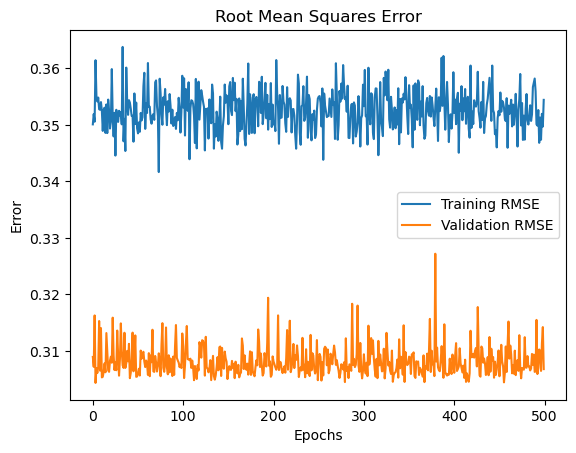

In [38]:
# Plot RMSE for training, validation, and test sets
plt.plot(hist.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

41/41 [==============================] - 0s 3ms/step
Validation Metrics:
Mean Squared Error (MSE): 261.5938470844185
Mean Absolute Error (MAE): 8.903700587386545
R-squared (R²) Score: 0.8854493320966909
Mean Absolute Percentage Error (MAPE): 0.32352107375897166


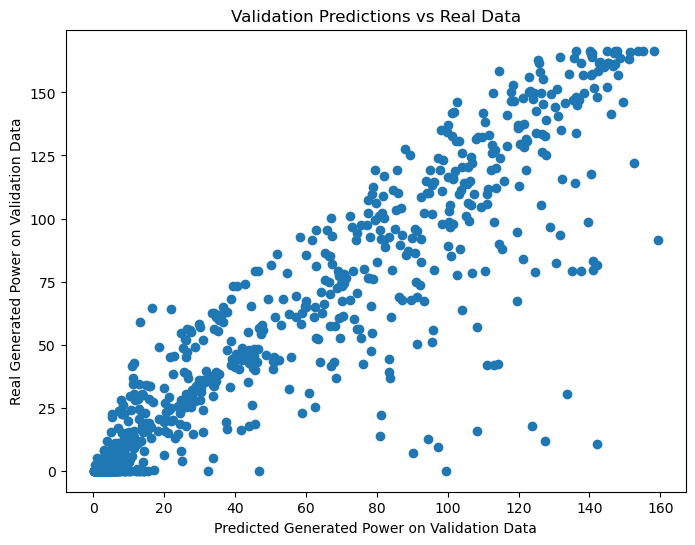

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


val_pred = spfnet.predict(X_val)
val_pred_orig = sc_y.inverse_transform(val_pred)

mse_val = mean_squared_error(sc_y.inverse_transform(y_val), val_pred_orig)
mae_val = mean_absolute_error(sc_y.inverse_transform(y_val), val_pred_orig)
r2_val = r2_score(sc_y.inverse_transform(y_val), val_pred_orig)
average_actual_val_yield = np.mean(sc_y.inverse_transform(y_val))
average_predicted_val_yield = np.mean(val_pred_orig)
mape_val = np.abs((average_actual_val_yield - average_predicted_val_yield) / average_actual_val_yield) * 100

print("Validation Metrics:")
print("Mean Squared Error (MSE):", mse_val)
print("Mean Absolute Error (MAE):", mae_val)
print("R-squared (R²) Score:", r2_val)
print("Mean Absolute Percentage Error (MAPE):", mape_val)

# Scatter plot for validation set predictions vs real data
plt.figure(figsize=(8, 6))
plt.scatter(val_pred_orig, sc_y.inverse_transform(y_val))
plt.xlabel('Predicted Generated Power on Validation Data')
plt.ylabel('Real Generated Power on Validation Data')
plt.title('Validation Predictions vs Real Data')
plt.show()

#Mean Squared Error (MSE): 261.8761545613471
#Mean Absolute Error (MAE): 7.952502485952005
#R-squared (R²) Score: 0.8853257110314529
#Mean Absolute Percentage Error (MAPE): 1.1668585625188823

41/41 [==============================] - 0s 3ms/step
Test Metrics:
Mean Squared Error (MSE): 203.77340490834928
Mean Absolute Error (MAE): 8.126094341434094
R-squared (R²) Score: 0.903692025068509
Mean Absolute Percentage Error (MAPE): 1.9905527733338253


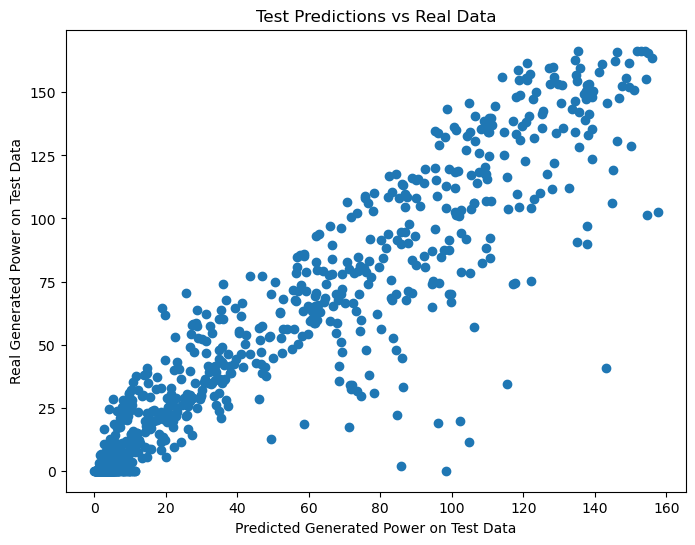

In [40]:
# Predictions and metrics for test set
test_pred = spfnet.predict(X_test)
test_pred_orig = sc_y.inverse_transform(test_pred)

mse_test = mean_squared_error(sc_y.inverse_transform(y_test), test_pred_orig)
mae_test = mean_absolute_error(sc_y.inverse_transform(y_test), test_pred_orig)
r2_test = r2_score(sc_y.inverse_transform(y_test), test_pred_orig)
average_actual_test_yield = np.mean(sc_y.inverse_transform(y_test))
average_predicted_test_yield = np.mean(test_pred_orig)
mape_test = np.abs((average_actual_test_yield - average_predicted_test_yield) / average_actual_test_yield) * 100

print("Test Metrics:")
print("Mean Squared Error (MSE):", mse_test)
print("Mean Absolute Error (MAE):", mae_test)
print("R-squared (R²) Score:", r2_test)
print("Mean Absolute Percentage Error (MAPE):", mape_test)

# Scatter plot for test set predictions vs real data
plt.figure(figsize=(8, 6))
plt.scatter(test_pred_orig, sc_y.inverse_transform(y_test))
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Real Data')
plt.show()

#ean Squared Error (MSE): 202.32157741420102
#Mean Absolute Error (MAE): 7.290129131378513
#R-squared (R²) Score: 0.9043781919702898
#Mean Absolute Percentage Error (MAPE): 3.2317580229732994

190/190 [==============================] - 1s 3ms/step
Training Metrics:
Mean Squared Error (MSE): 211.19052577597287
Mean Absolute Error (MAE): 8.140212793471294
R-squared (R²) Score: 0.9024678249736389
Mean Absolute Percentage Error (MAPE): 0.10009500845643655


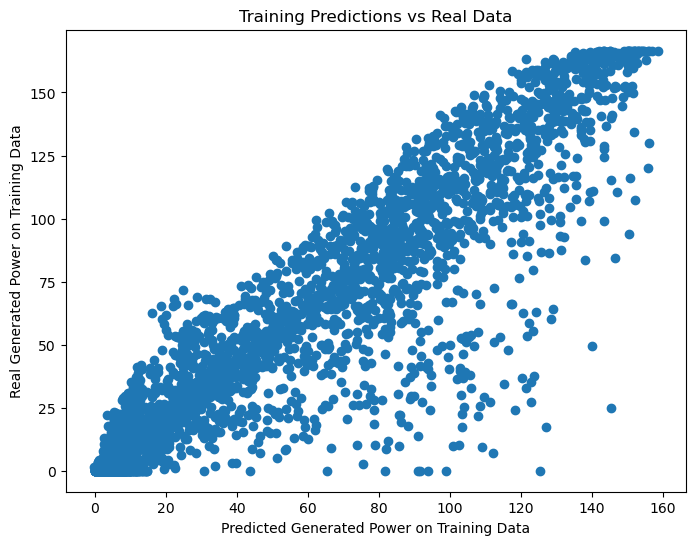

In [41]:
# Predictions and metrics for training set
train_pred = spfnet.predict(X_train)
train_pred_orig = sc_y.inverse_transform(train_pred)

mse_train = mean_squared_error(sc_y.inverse_transform(y_train), train_pred_orig)
mae_train = mean_absolute_error(sc_y.inverse_transform(y_train), train_pred_orig)
r2_train = r2_score(sc_y.inverse_transform(y_train), train_pred_orig)
average_actual_train_yield = np.mean(sc_y.inverse_transform(y_train))
average_predicted_train_yield = np.mean(train_pred_orig)
mape_train = np.abs((average_actual_train_yield - average_predicted_train_yield) / average_actual_train_yield) * 100

print("Training Metrics:")
print("Mean Squared Error (MSE):", mse_train)
print("Mean Absolute Error (MAE):", mae_train)
print("R-squared (R²) Score:", r2_train)
print("Mean Absolute Percentage Error (MAPE):", mape_train)

# Scatter plot for training set predictions vs real data
plt.figure(figsize=(8, 6))
plt.scatter(train_pred_orig, sc_y.inverse_transform(y_train))
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()

#Mean Squared Error (MSE): 213.62886111804423
#Mean Absolute Error (MAE): 7.24703570816315
#R-squared (R²) Score: 0.9013417510246202
#Mean Absolute Percentage Error (MAPE): 0.8297529292836049
